In [1]:
%%time
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.backends.backend_pdf
pd.options.mode.chained_assignment = None  # default='warn'

import sprawl
from sprawl import plotting

import glob
import os

CPU times: user 1.85 s, sys: 669 ms, total: 2.52 s
Wall time: 1min 24s


# Distribution plots

Jan 28th 2023, making distribution plots like: analysis/benchmarking_on_simulated_data/radial_punctate_overclustering_in_real_data.ipynb for an eLife submission

Will have a separate plot for each dataset and will make a histogram which I think will be easier to read

In [15]:
%%time
mop_real_paths = glob.glob('../../nf_pipeline/outputs/BICCN_20220601_direct/gene_ont/*.csv')
mop_perm_paths = glob.glob('../../nf_pipeline/outputs/SRRS_20220531_permuted/gene_ont/BICCN*.csv')
vzbrain_real_paths = glob.glob('../../nf_pipeline/outputs/vz_Brainmap_20220602_direct/gene_ont/*.csv')
vzbrain_perm_paths = glob.glob('../../nf_pipeline/outputs/SRRS_20220531_permuted/gene_ont/vz_Brainmap*.csv')
vzliver_real_paths = glob.glob('../../nf_pipeline/outputs/vz_Liver_20220601_direct/gene_ont/*.csv')
vzliver_perm_paths = glob.glob('../../nf_pipeline/outputs/vz_Liver_perm/gene_ont/*.csv')

real_paths = mop_real_paths+vzbrain_real_paths+vzliver_real_paths
perm_paths = mop_perm_paths+vzbrain_perm_paths+vzliver_perm_paths

#Read in
real_df = pd.concat(pd.read_csv(p) for p in real_paths)
perm_df = pd.concat(pd.read_csv(p) for p in perm_paths)
real_df['Status'] = 'Real'
perm_df['Status'] = 'Permuted'
df = pd.concat((real_df,perm_df))

CPU times: user 783 ms, sys: 192 ms, total: 975 ms
Wall time: 4.37 s


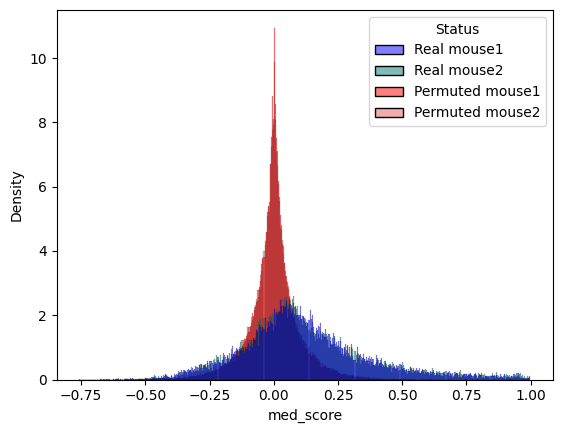

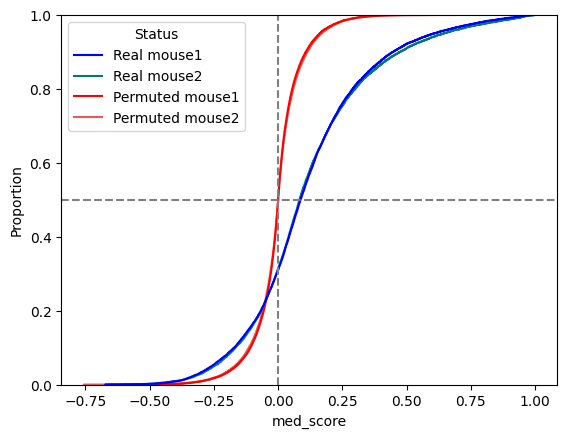

In [16]:
#should I make these eCDF plots?
plot_df = df[df['experiment'].str.startswith('BICCN')].copy()
plot_df['Status'] += np.where(plot_df['experiment'].eq('BICCN_mouse1'),' mouse1',' mouse2')
palette = {
    'Real mouse1':'blue',
    'Real mouse2':'#027979', #greenish-blue
    'Permuted mouse1':'red',
    'Permuted mouse2':'#E75C58', #lightish-red
}

sns.histplot(
    x = 'med_score',
    hue = 'Status',
    palette = palette,
    stat = 'density',
    common_norm = False,
    data = plot_df,
)
plt.show()
plt.close()

sns.ecdfplot(
    x = 'med_score',
    hue = 'Status',
    palette = palette,
    data = plot_df,
)
plt.axhline(0.5, linestyle='dashed', color='grey')
plt.axvline(0, linestyle='dashed', color='grey')

plt.show()
plt.close()

# Combined plot

Aug 23rd, combining real and simulated data plots

Also combining MOp, VzBrain, and VzLung to make a multipanel figure

In [17]:
%%time
mop_real_paths = glob.glob('../../nf_pipeline/outputs/BICCN_20220601_direct/gene_ont/*.csv')
mop_perm_paths = glob.glob('../../nf_pipeline/outputs/SRRS_20220531_permuted/gene_ont/BICCN*.csv')
vzbrain_real_paths = glob.glob('../../nf_pipeline/outputs/vz_Brainmap_20220602_direct/gene_ont/*.csv')
vzbrain_perm_paths = glob.glob('../../nf_pipeline/outputs/SRRS_20220531_permuted/gene_ont/vz_Brainmap*.csv')
vzliver_real_paths = glob.glob('../../nf_pipeline/outputs/vz_Liver_20220601_direct/gene_ont/*.csv')
vzliver_perm_paths = glob.glob('../../nf_pipeline/outputs/vz_Liver_perm/gene_ont/*.csv')

real_paths = mop_real_paths+vzbrain_real_paths+vzliver_real_paths
perm_paths = mop_perm_paths+vzbrain_perm_paths+vzliver_perm_paths

#Read in
real_df = pd.concat(pd.read_csv(p) for p in real_paths)
perm_df = pd.concat(pd.read_csv(p) for p in perm_paths)
real_df['Status'] = 'Real'
perm_df['Status'] = 'Permuted'
df = pd.concat((real_df,perm_df))


#Create dataset/replicate columns
experiment_to_dataset = {
    'BICCN_mouse1':'BICCN',
    'BICCN_mouse2':'BICCN',
    'vz_Brainmap_slice1':'vz_Brain',
    'vz_Brainmap_slice2':'vz_Brain',
    'vz_Liver_mouse1':'vz_Liver',
    'vz_Liver_mouse2':'vz_Liver',
}

experiment_to_replicate = {
    'BICCN_mouse1':'Replicate 1',
    'BICCN_mouse2':'Replicate 2',
    'vz_Brainmap_slice1':'Replicate 1',
    'vz_Brainmap_slice2':'Replicate 2',
    'vz_Liver_mouse1':'Replicate 1',
    'vz_Liver_mouse2':'Replicate 2',
}

df = (df
      .assign(dataset = df['experiment'].map(experiment_to_dataset))
      .assign(replicate = df['experiment'].map(experiment_to_replicate))
)
df['Significance'] = np.where(df['bh_p'].le(0.05),'Significant','Insignificant')

#pivot for plotting, averaging med scores if multiple samples exist (m1s1, m1s2, etc)
plot_df = df.pivot_table(
    index=['dataset','Status','metric','gene','annotation','Significance'],
    columns='replicate',
    values='med_score',
).reset_index()

#Radial permuted runs still in progress, add fake permuted data for plot
vz_perm_proxy = plot_df[
    plot_df['dataset'].eq('vz_Liver')
    & plot_df['metric'].eq('puncta')
    & plot_df['Status'].eq('Permuted')
].copy()

vz_perm_proxy['metric'] = 'radial'
plot_df = pd.concat((vz_perm_proxy,plot_df))

plot_df

CPU times: user 1.89 s, sys: 171 ms, total: 2.06 s
Wall time: 2.42 s


replicate,dataset,Status,metric,gene,annotation,Significance,Replicate 1,Replicate 2
221101,vz_Liver,Permuted,radial,0,0,Insignificant,0.004,0.008
221102,vz_Liver,Permuted,radial,0,1,Insignificant,-0.014,0.014
221103,vz_Liver,Permuted,radial,0,2,Insignificant,-0.008,-0.006
221104,vz_Liver,Permuted,radial,0,3,Insignificant,-0.010,-0.004
221105,vz_Liver,Permuted,radial,0,4,Insignificant,0.012,0.012
...,...,...,...,...,...,...,...,...
301577,vz_Liver,Real,radial,Wnt4,24,Significant,0.220,0.089
301578,vz_Liver,Real,radial,Wnt4,25,Significant,0.454,0.550
301579,vz_Liver,Real,radial,Wnt4,27,Insignificant,NaN,0.074
301580,vz_Liver,Real,radial,Wnt4,27,Significant,0.208,NaN


In [ ]:
df.head()

PearsonRResult(statistic=0.9000566514624679, pvalue=0.0)


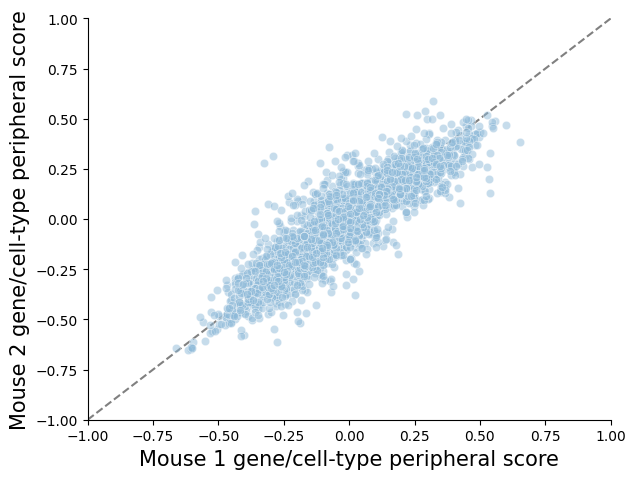

PearsonRResult(statistic=0.003200944675059183, pvalue=0.6687288091892918)


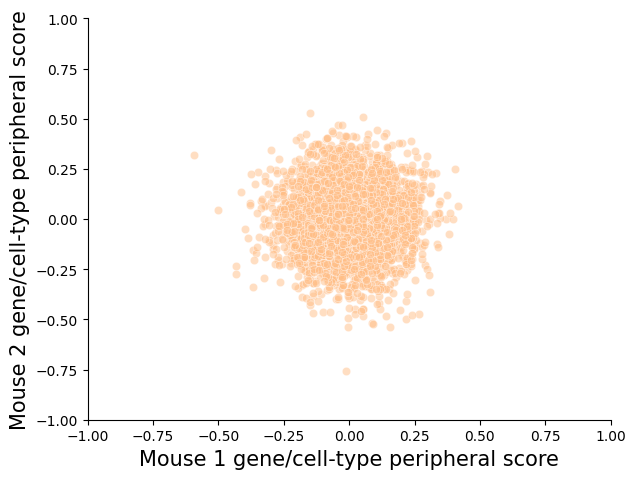

CPU times: user 543 ms, sys: 115 ms, total: 658 ms
Wall time: 1.25 s


In [18]:
%%time

#Just make a BICCN peripheral focused plot
#the larger plot below with all datasets and all metrics can be supplemental
g = plot_df[
    plot_df['dataset'].eq('BICCN')
    & plot_df['metric'].eq('periph')
].copy()

#Real data
has_both_r1r2 = g['Replicate 1'].notnull() & g['Replicate 2'].notnull()

real_pearson = stats.pearsonr(
    g.loc[g['Status'].eq('Real') & has_both_r1r2,'Replicate 1'],
    g.loc[g['Status'].eq('Real') & has_both_r1r2,'Replicate 2'],
)

print(real_pearson)

sns.scatterplot(
    data = g[g['Status'].eq('Real')],
    x = 'Replicate 1',
    y = 'Replicate 2',
    color = '#8EBAD9',
    alpha = 0.5,
)
# plt.axhline(0,linestyle='dashed',color='grey',zorder=-1)
# plt.axvline(0,linestyle='dashed',color='grey',zorder=-1)
plt.plot([-1,1],[-1,1],linestyle='dashed',color='grey',zorder=-1)
            
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.tight_layout()
plt.xlabel('Mouse 1 gene/cell-type peripheral score', fontsize='15')
plt.ylabel('Mouse 2 gene/cell-type peripheral score', fontsize='15')

sns.despine(left=False, bottom=False)
#plt.savefig('combined_gene_ont_corrs_scatter.png')
plt.show()
plt.close()


#Permuted data
has_both_r1r2 = g['Replicate 1'].notnull() & g['Replicate 2'].notnull()

permuted_pearson = stats.pearsonr(
    g.loc[g['Status'].eq('Permuted') & has_both_r1r2,'Replicate 1'],
    g.loc[g['Status'].eq('Permuted') & has_both_r1r2,'Replicate 2'],
)

print(permuted_pearson)

sns.scatterplot(
    data = g[g['Status'].eq('Permuted')],
    x = 'Replicate 1',
    y = 'Replicate 2',
    color = '#FFBE86',
    alpha = 0.5,
)
# plt.axhline(0,linestyle='dashed',color='grey',zorder=-1)
# plt.axvline(0,linestyle='dashed',color='grey',zorder=-1)
#plt.plot([-1,1],[-1,1],linestyle='dashed',color='grey',zorder=-1)
            
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.tight_layout()
plt.xlabel('Mouse 1 gene/cell-type peripheral score', fontsize='15')
plt.ylabel('Mouse 2 gene/cell-type peripheral score', fontsize='15')

sns.despine(left=False, bottom=False)
#plt.savefig('combined_gene_ont_corrs_scatter.png')
plt.show()
plt.close()

# All samples and metrics permuted vs. real

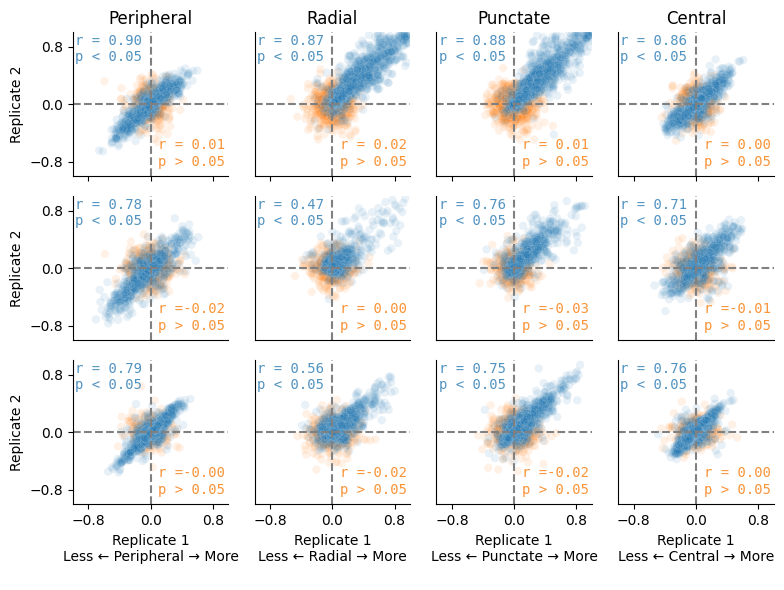

CPU times: user 4.81 s, sys: 24.9 ms, total: 4.84 s
Wall time: 4.81 s


In [45]:
%%time

sub_plot_df = plot_df.groupby(['dataset','Status','metric']).sample(2000)

nrows = plot_df['dataset'].nunique()
ncols = plot_df['metric'].nunique()

fig,axs = plt.subplots(
    figsize = (ncols*2,nrows*2),
    nrows=nrows, ncols=ncols,
    sharex=True, sharey=True,
)

dataset_order = ['BICCN', 'vz_Brain', 'vz_Liver']
metric_order = ['periph','radial','puncta','central']
metric_to_title = {
    'periph':'Peripheral',
    'radial':'Radial',
    'puncta':'Punctate',
    'central':'Central',
}

for row,dataset in enumerate(dataset_order):
    for col,metric in enumerate(metric_order):
        ax = axs[row][col]
        title=metric_to_title[metric]
        
        g = sub_plot_df[
            sub_plot_df['dataset'].eq(dataset)
            & sub_plot_df['metric'].eq(metric)
        ]
        sns.scatterplot(
            data = g,
            x = 'Replicate 1',
            y = 'Replicate 2',
            hue = 'Status',
            hue_order = ['Real','Permuted'],
            alpha = 0.1,
            ax = ax,
        )
        ax.axhline(0,linestyle='dashed',color='grey')
        ax.axvline(0,linestyle='dashed',color='grey')
        
        #add correlation coefficients of real/permtued
        full_g = plot_df[
            plot_df['dataset'].eq(dataset)
            & plot_df['metric'].eq(metric)
        ]
        
        real_pearson_r = full_g[
            full_g['Status'].eq('Real')
        ][['Replicate 1','Replicate 2']].corr(method='spearman').values[0,1]
        
        perm_pearson_r = full_g[
            full_g['Status'].eq('Permuted')
        ][['Replicate 1','Replicate 2']].corr(method='spearman').values[0,1]
        
        ax.text(-0.97,0.6,'r = {:.2f}\np < 0.05'.format(real_pearson_r),color='#5193C0', fontname='monospace')
        ax.text(0.1,-0.85,'r ='+(' ' if perm_pearson_r > 0 else '')+'{:.2f}\np > 0.05'.format(perm_pearson_r),color='#F99439', fontname='monospace')
        
        #Remove labels and legend
        ax.get_legend().remove()
        ax.set_xlabel('')
        ax.set_ylabel('')
        
        #Remove internal axes
        if col == 0:
            ax.set_yticks([-0.8,0,0.8])
            ax.set_ylabel('Replicate 2')
        else:
            ax.yaxis.set_visible(False)
            
        if row == 0:
            ax.set_title(title)
        elif row == nrows-1:
            ax.set_xticks([-0.8,0,0.8])
            ax.set_xlabel(
"""Replicate 1
Less ← {} → More
""".format(title))
        else:
            ax.xaxis.set_visible(False)
            
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.tight_layout()
sns.despine(left=False, bottom=False)
plt.savefig('simplified_combined_gene_ont_corrs_scatter.png')
plt.show()
plt.close()

# All samples and metrics correlations sig/insig/permuted

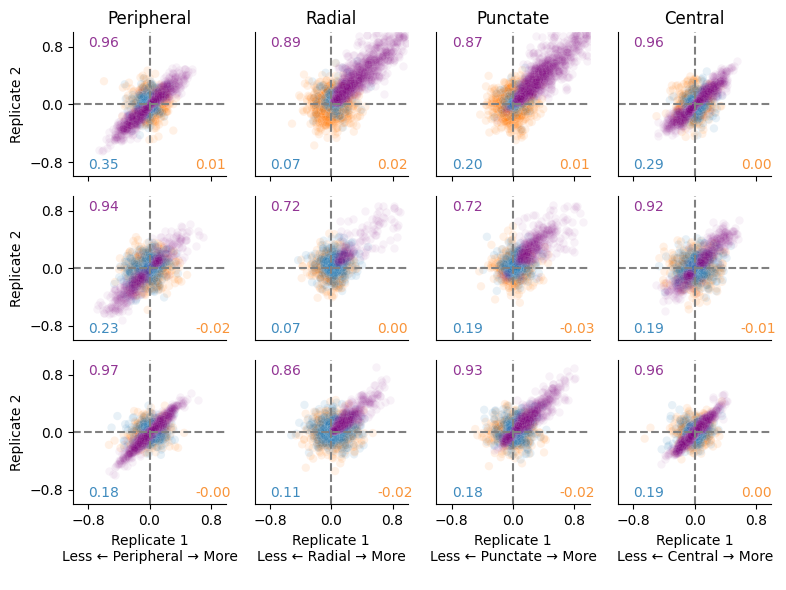

CPU times: user 4.69 s, sys: 176 ms, total: 4.86 s
Wall time: 5.01 s


In [19]:
%%time

sub_plot_df = plot_df.groupby(['dataset','Status','metric']).sample(2000)

nrows = plot_df['dataset'].nunique()
ncols = plot_df['metric'].nunique()

fig,axs = plt.subplots(
    figsize = (ncols*2,nrows*2),
    nrows=nrows, ncols=ncols,
    sharex=True, sharey=True,
)

dataset_order = ['BICCN', 'vz_Brain', 'vz_Liver']
metric_order = ['periph','radial','puncta','central']
metric_to_title = {
    'periph':'Peripheral',
    'radial':'Radial',
    'puncta':'Punctate',
    'central':'Central',
}

for row,dataset in enumerate(dataset_order):
    for col,metric in enumerate(metric_order):
        ax = axs[row][col]
        title=metric_to_title[metric]
        
        g = sub_plot_df[
            sub_plot_df['dataset'].eq(dataset)
            & sub_plot_df['metric'].eq(metric)
        ]
        sns.scatterplot(
            data = g[g['Significance'].eq('Insignificant')],
            x = 'Replicate 1',
            y = 'Replicate 2',
            hue = 'Status',
            hue_order = ['Real','Permuted'],
            alpha = 0.1,
            ax = ax,
        )
        sns.scatterplot(
            data = g[g['Significance'].eq('Significant')],
            x = 'Replicate 1',
            y = 'Replicate 2',
            color = 'purple',
            alpha = 0.05,
            ax = ax,
        )
        ax.axhline(0,linestyle='dashed',color='grey')
        ax.axvline(0,linestyle='dashed',color='grey')
        
        #add correlation coefficients of real/permtued
        full_g = plot_df[
            plot_df['dataset'].eq(dataset)
            & plot_df['metric'].eq(metric)
        ]
        
        sig_pearson_r = full_g[
            full_g['Status'].eq('Real')
            & full_g['Significance'].eq('Significant')
        ][['Replicate 1','Replicate 2']].corr(method='spearman').values[0,1]
        
        insig_pearson_r = full_g[
            full_g['Status'].eq('Real')
            & full_g['Significance'].eq('Insignificant')
        ][['Replicate 1','Replicate 2']].corr(method='spearman').values[0,1]
        
        perm_pearson_r = full_g[full_g['Status'].eq('Permuted')][['Replicate 1','Replicate 2']].corr(method='spearman').values[0,1]
        
        ax.text(-0.8,0.8,'{:.2f}'.format(sig_pearson_r),color='#923594')
        ax.text(-0.8,-0.9,'{:.2f}'.format(insig_pearson_r),color='#3F8BBE')
        ax.text(0.6,-0.9,'{:.2f}'.format(perm_pearson_r),color='#F99439')
        
        #plot timp3 spots in a different color on top
#         timp3_g = plot_df[
#             plot_df['dataset'].eq(dataset)
#             & plot_df['metric'].eq(metric)
#             & plot_df['gene'].eq('Timp3')
#             & plot_df['Status'].eq('Real')
#         ]
#         sns.scatterplot(
#             data = timp3_g,
#             x = 'Replicate 1',
#             y = 'Replicate 2',
#             color = 'black',
#             alpha = 1,
#             ax = ax,
#         )
        
        #Remove labels and legend
        ax.get_legend().remove()
        ax.set_xlabel('')
        ax.set_ylabel('')
        
        #Remove internal axes
        if col == 0:
            ax.set_yticks([-0.8,0,0.8])
            ax.set_ylabel('Replicate 2')
        else:
            ax.yaxis.set_visible(False)
            
        if row == 0:
            ax.set_title(title)
        elif row == nrows-1:
            ax.set_xticks([-0.8,0,0.8])
            ax.set_xlabel(
"""Replicate 1
Less ← {} → More
""".format(title))
        else:
            ax.xaxis.set_visible(False)
            
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.tight_layout()
sns.despine(left=False, bottom=False)
plt.savefig('combined_gene_ont_corrs_scatter.png')
plt.show()
plt.close()

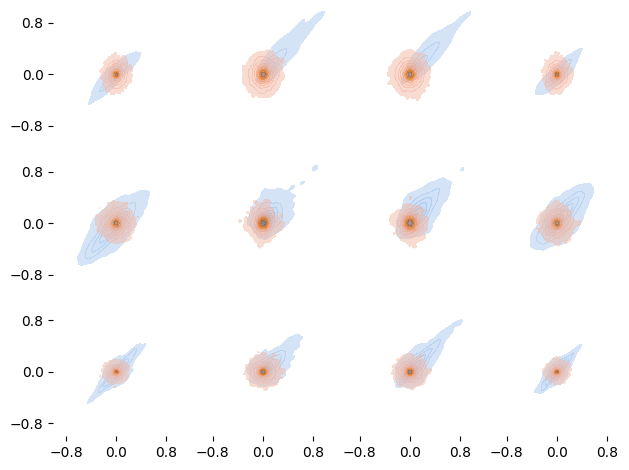

CPU times: user 3min 20s, sys: 167 ms, total: 3min 21s
Wall time: 3min 38s


In [132]:
%%time

nrows = plot_df['dataset'].nunique()
ncols = plot_df['metric'].nunique()

fig,axs = plt.subplots(
    nrows=nrows, ncols=ncols,
    sharex=True, sharey=True,
)

dataset_order = ['BICCN', 'vz_Brain', 'vz_Liver']
metric_order = ['periph','radial','puncta','central']

for row,dataset in enumerate(dataset_order):
    for col,metric in enumerate(metric_order):
        ax = axs[row][col]
        
        g = plot_df[
            plot_df['dataset'].eq(dataset)
            & plot_df['metric'].eq(metric)
        ]
        sns.kdeplot(
            data = g,
            x = 'Replicate 1',
            y = 'Replicate 2',
            hue = 'Status',
            hue_order = ['Real','Permuted'],
            fill = True,
            alpha = 0.5,
            ax = ax,
        )
        ax.get_legend().remove()
        ax.set_xlabel('')
        ax.set_ylabel('')
    
        #Remove internal axes
        if col == 0:
            ax.set_yticks([-0.8,0,0.8])
        else:
            ax.yaxis.set_visible(False)
            
        if row == nrows-1:
            ax.set_xticks([-0.8,0,0.8])
        else:
            ax.xaxis.set_visible(False)
            
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.tight_layout()
sns.despine(left=True, bottom=True)
plt.savefig('combined_gene_ont_corrs_kde.svg')
plt.show()
plt.close()

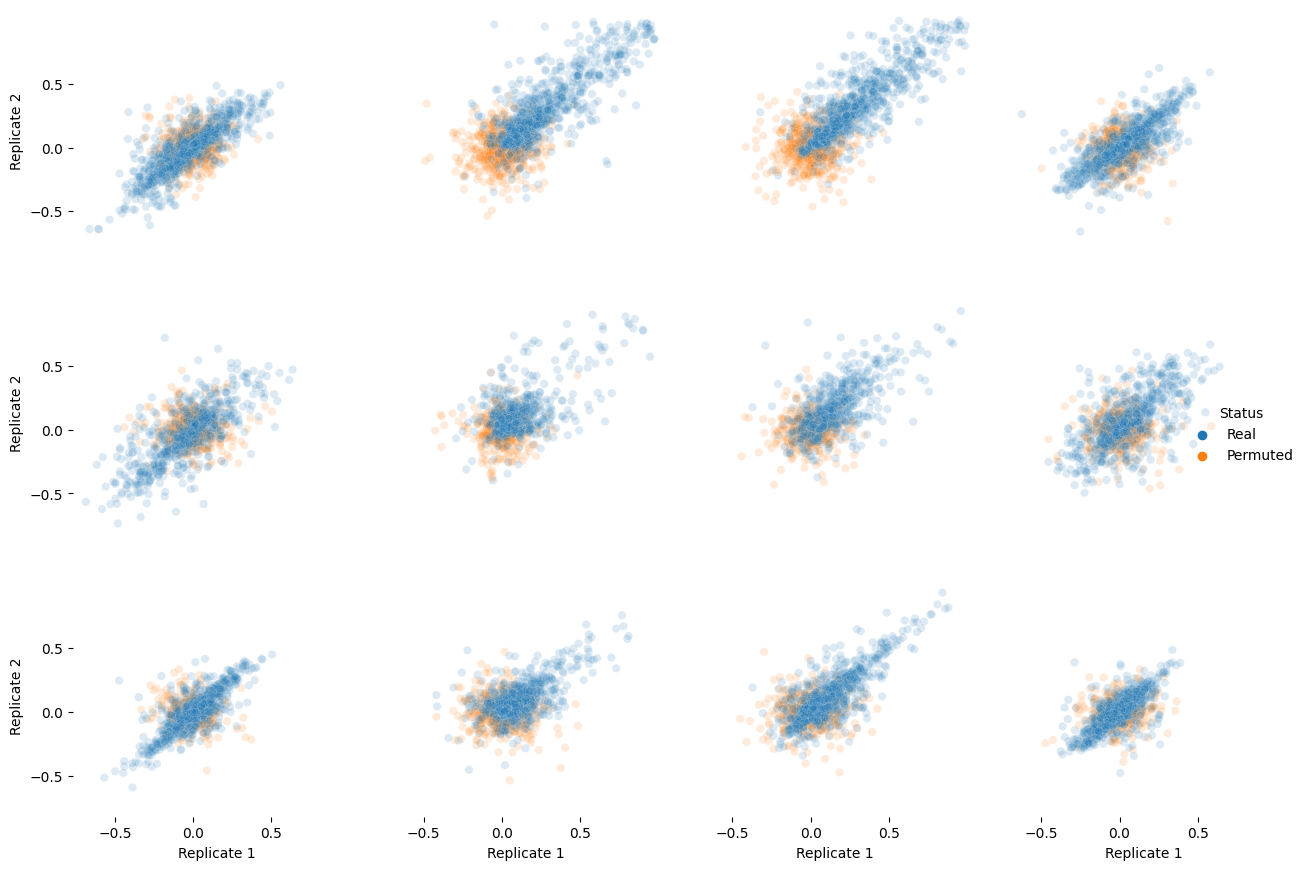

CPU times: user 4.99 s, sys: 232 ms, total: 5.22 s
Wall time: 20.9 s


In [133]:
%%time
#Scatterplot, results in too large of an SVG to process
#Subsample the points to make the plots fewer megabytes
plot_df = plot_df.groupby(['dataset','Status','metric']).sample(1000)

#Plot
f = sns.relplot(
    data = plot_df,
    x = 'Replicate 1',
    y = 'Replicate 2',
    row = 'dataset',
    row_order = ['BICCN','vz_Brain','vz_Liver'],
    col = 'metric',
    col_order = ['periph','radial','puncta','central'],
    hue = 'Status',
    hue_order = ['Real','Permuted'],
    alpha = 0.15,
    height = 3,
    aspect = 1,
)
plt.tight_layout()
sns.despine(left=True, bottom=True) #whether or not to show the axes
f.set_titles('') #remove subplot titles, I'll add them myself in inkscape

#set the x/y ticks to have fewer marks for edge subpplots
#remove ticks from interior subplots by turning off axes
for row,axs in enumerate(f.axes):
    for col,ax in enumerate(axs):
        ax.set_xticks([-0.5, 0, 0.5])
        ax.set_yticks([-0.5, 0, 0.5])
        
        #if not a left-column subplot, turn off y-axis
        if col != 0:
            ax.yaxis.set_visible(False)

        #if not a bottom-row subplot, turn off x-axis    
        if row != len(f.axes)-1:
            ax.xaxis.set_visible(False)

#Couldn't get this right, squish together in inkscape
#f.figure.subplots_adjust(hspace=-0.15,wspace=-0.15) #'squish' subplots together

plt.savefig('combined_gene_ont_corrs_scatter.svg')
plt.show()
plt.close()

In [58]:
f.axes.se

In [28]:
f

# Plot of real values

In [3]:
experiment_samples = {
    'vz_Liver':[
        '../../nf_pipeline/outputs/vz_Liver_20220601_direct/gene_ont/vz_Liver_mouse1',
        '../../nf_pipeline/outputs/vz_Liver_20220601_direct/gene_ont/vz_Liver_mouse2',
    ],
    'BICCN':[
        '../../nf_pipeline/outputs/BICCN_20220601_direct/gene_ont/BICCN_mouse1',
        '../../nf_pipeline/outputs/BICCN_20220601_direct/gene_ont/BICCN_mouse2',
    ],
    'vz_Brainmap':[
        '../../nf_pipeline/outputs/vz_Brainmap_20220602_direct/gene_ont/vz_Brainmap_slice1',
        '../../nf_pipeline/outputs/vz_Brainmap_20220602_direct/gene_ont/vz_Brainmap_slice2',
        '../../nf_pipeline/outputs/vz_Brainmap_20220602_direct/gene_ont/vz_Brainmap_slice3',
    ],
}

sample,vz_Liver_mouse1,vz_Liver_mouse2
sample,,
vz_Liver_mouse1,1.000000,0.797723
vz_Liver_mouse2,0.797723,1.000000


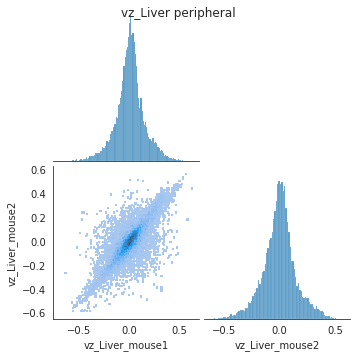

sample,vz_Liver_mouse1,vz_Liver_mouse2
sample,,
vz_Liver_mouse1,1.000000,0.966967
vz_Liver_mouse2,0.966967,1.000000


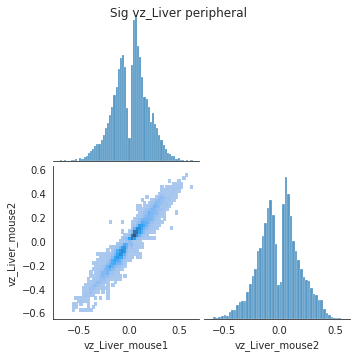

sample,vz_Liver_mouse1,vz_Liver_mouse2
sample,,
vz_Liver_mouse1,1.000000,0.739915
vz_Liver_mouse2,0.739915,1.000000


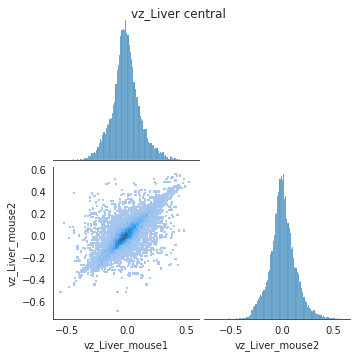

sample,vz_Liver_mouse1,vz_Liver_mouse2
sample,,
vz_Liver_mouse1,1.00000,0.96229
vz_Liver_mouse2,0.96229,1.00000


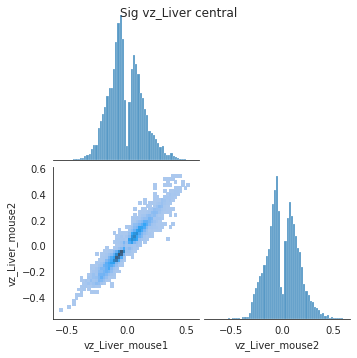

sample,vz_Liver_mouse1,vz_Liver_mouse2
sample,,
vz_Liver_mouse1,1.000000,0.620016
vz_Liver_mouse2,0.620016,1.000000


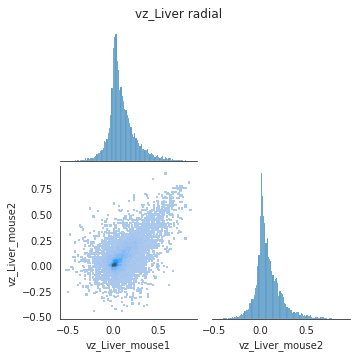

sample,vz_Liver_mouse1,vz_Liver_mouse2
sample,,
vz_Liver_mouse1,1.000000,0.862337
vz_Liver_mouse2,0.862337,1.000000


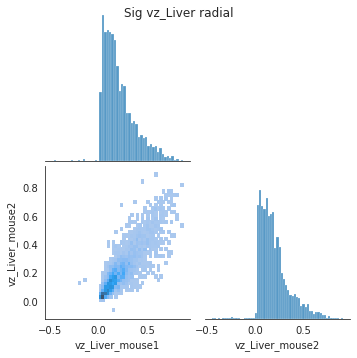

sample,vz_Liver_mouse1,vz_Liver_mouse2
sample,,
vz_Liver_mouse1,1.000000,0.771962
vz_Liver_mouse2,0.771962,1.000000


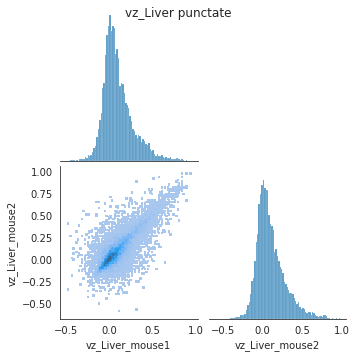

sample,vz_Liver_mouse1,vz_Liver_mouse2
sample,,
vz_Liver_mouse1,1.000000,0.935996
vz_Liver_mouse2,0.935996,1.000000


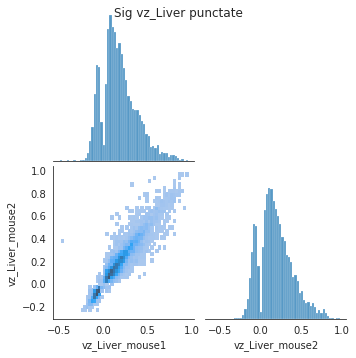

sample,BICCN_mouse1,BICCN_mouse2
sample,,
BICCN_mouse1,1.000000,0.842497
BICCN_mouse2,0.842497,1.000000


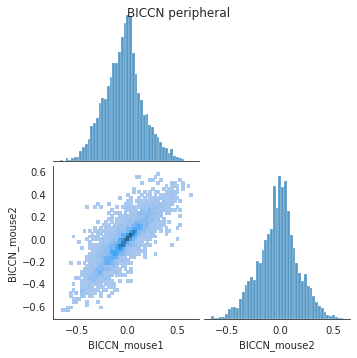

sample,BICCN_mouse1,BICCN_mouse2
sample,,
BICCN_mouse1,1.000000,0.948424
BICCN_mouse2,0.948424,1.000000


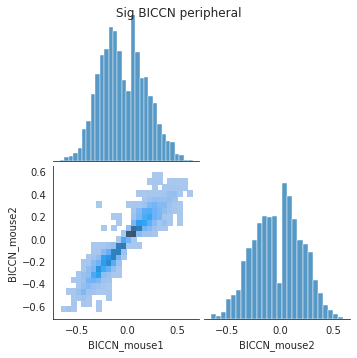

sample,BICCN_mouse1,BICCN_mouse2
sample,,
BICCN_mouse1,1.000000,0.804207
BICCN_mouse2,0.804207,1.000000


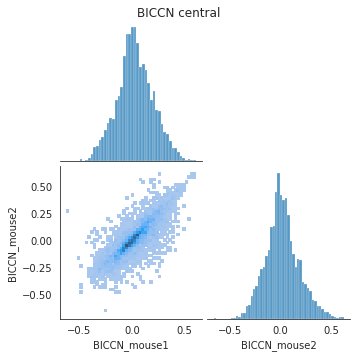

sample,BICCN_mouse1,BICCN_mouse2
sample,,
BICCN_mouse1,1.000000,0.949436
BICCN_mouse2,0.949436,1.000000


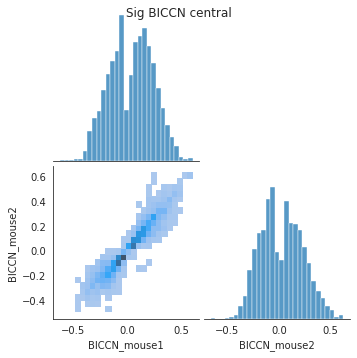

sample,BICCN_mouse1,BICCN_mouse2
sample,,
BICCN_mouse1,1.000000,0.818002
BICCN_mouse2,0.818002,1.000000


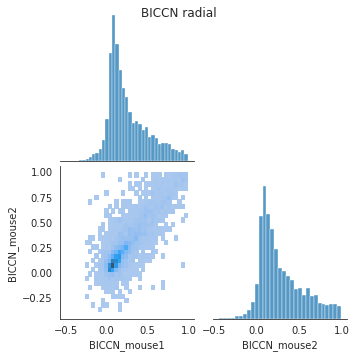

sample,BICCN_mouse1,BICCN_mouse2
sample,,
BICCN_mouse1,1.000000,0.882966
BICCN_mouse2,0.882966,1.000000


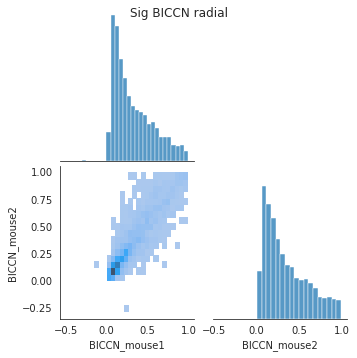

sample,BICCN_mouse1,BICCN_mouse2
sample,,
BICCN_mouse1,1.000000,0.810962
BICCN_mouse2,0.810962,1.000000


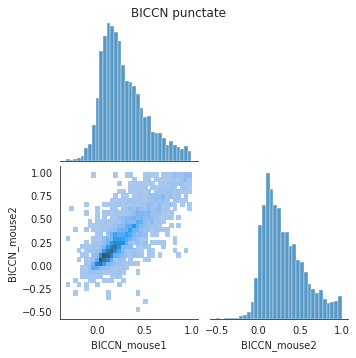

sample,BICCN_mouse1,BICCN_mouse2
sample,,
BICCN_mouse1,1.000000,0.858779
BICCN_mouse2,0.858779,1.000000


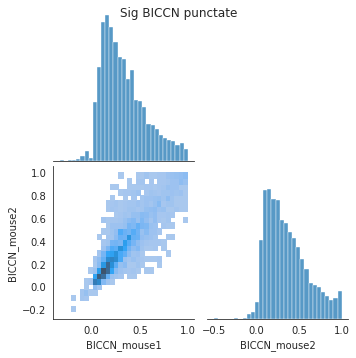

sample,vz_Brainmap_slice1,vz_Brainmap_slice2,vz_Brainmap_slice3
sample,,,
vz_Brainmap_slice1,1.000000,0.744148,0.750788
vz_Brainmap_slice2,0.744148,1.000000,0.755961
vz_Brainmap_slice3,0.750788,0.755961,1.000000


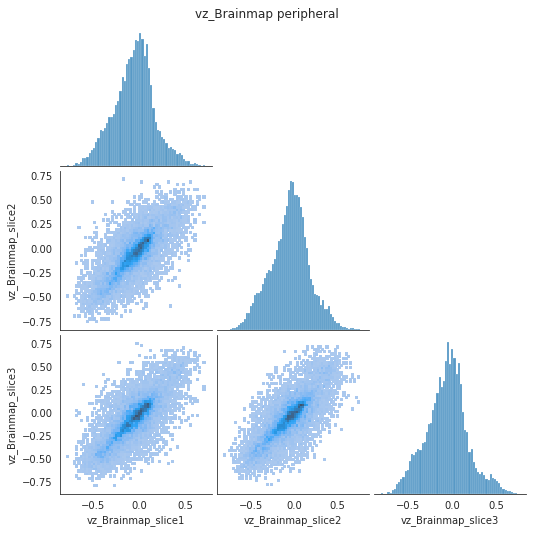

sample,vz_Brainmap_slice1,vz_Brainmap_slice2,vz_Brainmap_slice3
sample,,,
vz_Brainmap_slice1,1.000000,0.929591,0.928542
vz_Brainmap_slice2,0.929591,1.000000,0.930539
vz_Brainmap_slice3,0.928542,0.930539,1.000000


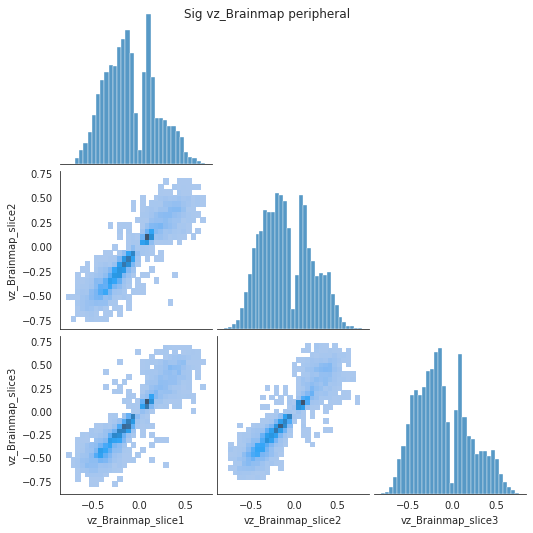

sample,vz_Brainmap_slice1,vz_Brainmap_slice2,vz_Brainmap_slice3
sample,,,
vz_Brainmap_slice1,1.000000,0.678930,0.693512
vz_Brainmap_slice2,0.678930,1.000000,0.713747
vz_Brainmap_slice3,0.693512,0.713747,1.000000


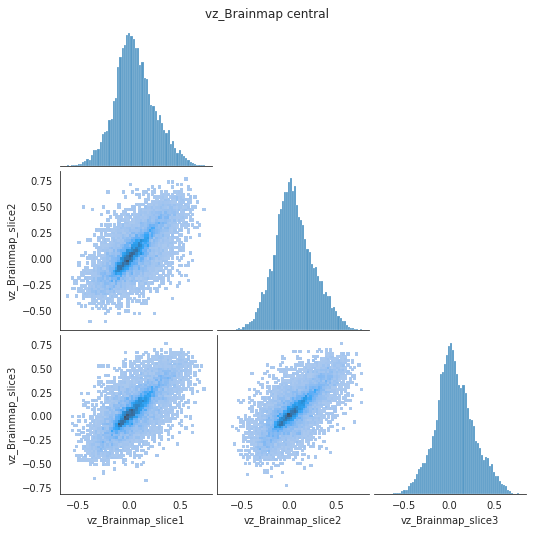

sample,vz_Brainmap_slice1,vz_Brainmap_slice2,vz_Brainmap_slice3
sample,,,
vz_Brainmap_slice1,1.000000,0.920230,0.926238
vz_Brainmap_slice2,0.920230,1.000000,0.926038
vz_Brainmap_slice3,0.926238,0.926038,1.000000


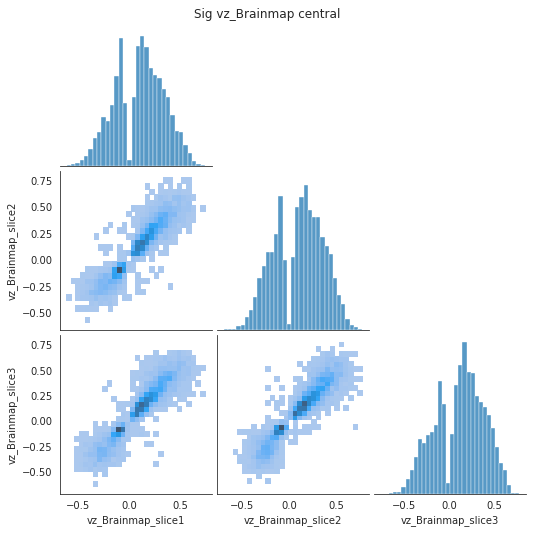

sample,vz_Brainmap_slice1,vz_Brainmap_slice2,vz_Brainmap_slice3
sample,,,
vz_Brainmap_slice1,1.000000,0.549144,0.522925
vz_Brainmap_slice2,0.549144,1.000000,0.537366
vz_Brainmap_slice3,0.522925,0.537366,1.000000


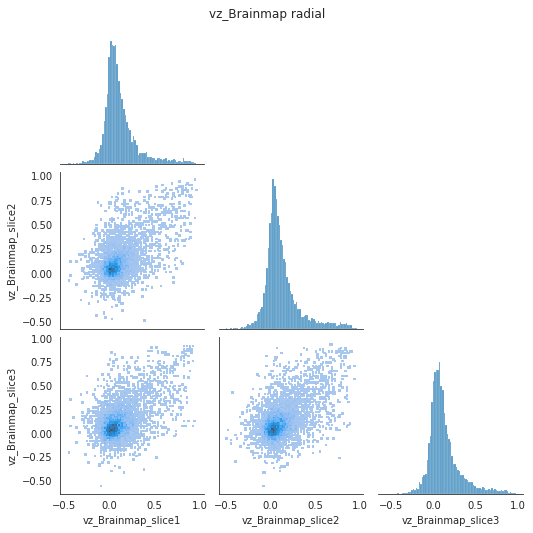

sample,vz_Brainmap_slice1,vz_Brainmap_slice2,vz_Brainmap_slice3
sample,,,
vz_Brainmap_slice1,1.000000,0.740212,0.716553
vz_Brainmap_slice2,0.740212,1.000000,0.704846
vz_Brainmap_slice3,0.716553,0.704846,1.000000


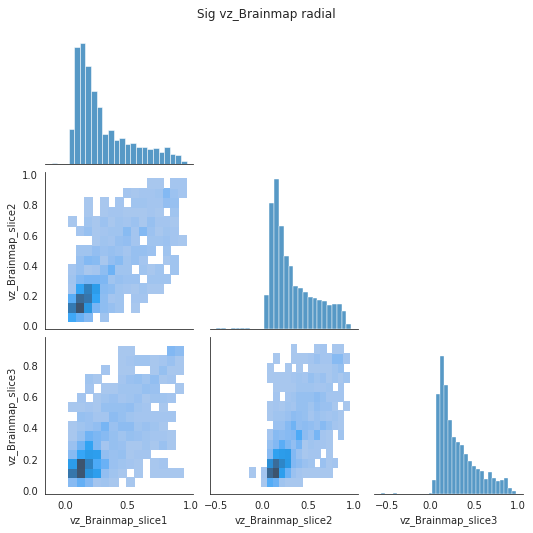

sample,vz_Brainmap_slice1,vz_Brainmap_slice2,vz_Brainmap_slice3
sample,,,
vz_Brainmap_slice1,1.000000,0.640660,0.617652
vz_Brainmap_slice2,0.640660,1.000000,0.614982
vz_Brainmap_slice3,0.617652,0.614982,1.000000


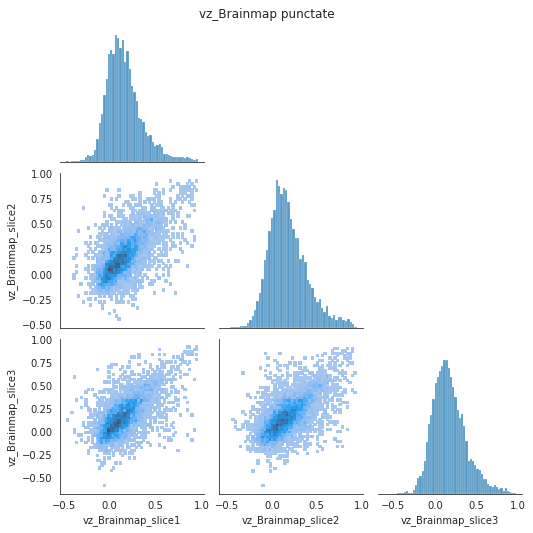

sample,vz_Brainmap_slice1,vz_Brainmap_slice2,vz_Brainmap_slice3
sample,,,
vz_Brainmap_slice1,1.000000,0.746643,0.716157
vz_Brainmap_slice2,0.746643,1.000000,0.727145
vz_Brainmap_slice3,0.716157,0.727145,1.000000


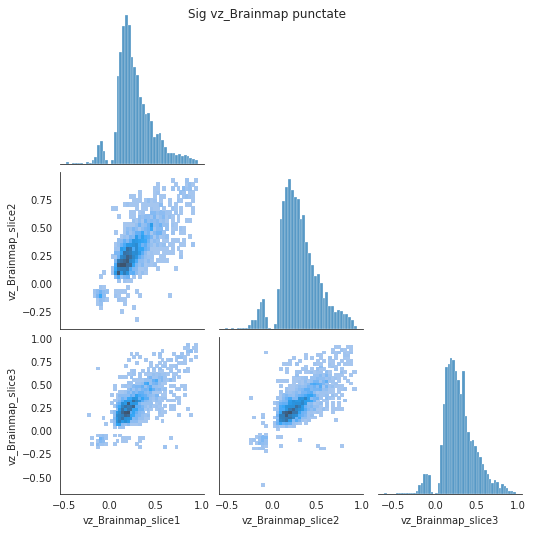

CPU times: user 51.8 s, sys: 864 ms, total: 52.7 s
Wall time: 52.9 s


In [5]:
%%time
#Pairplots for experiments with replicate samples
#uses the gene/ont datasets for plotting

sns.set_style("white")

metrics = ['peripheral','central','radial','punctate']
experiment_samples = {
    'vz_Liver':[
        '../../nf_pipeline/outputs/vz_Liver_20220601_direct/gene_ont/vz_Liver_mouse1',
        '../../nf_pipeline/outputs/vz_Liver_20220601_direct/gene_ont/vz_Liver_mouse2',
    ],
    'BICCN':[
        '../../nf_pipeline/outputs/BICCN_20220601_direct/gene_ont/BICCN_mouse1',
        '../../nf_pipeline/outputs/BICCN_20220601_direct/gene_ont/BICCN_mouse2',
    ],
    'vz_Brainmap':[
        '../../nf_pipeline/outputs/vz_Brainmap_20220602_direct/gene_ont/vz_Brainmap_slice1',
        '../../nf_pipeline/outputs/vz_Brainmap_20220602_direct/gene_ont/vz_Brainmap_slice2',
        '../../nf_pipeline/outputs/vz_Brainmap_20220602_direct/gene_ont/vz_Brainmap_slice3',
    ],
}

pdf = plotting.make_pdf('gene_ont_pairplots_real_data.pdf')

for experiment,samples in experiment_samples.items():
    for metric in metrics:
        df = pd.DataFrame()
        for sample in samples:
            f_path = glob.glob(sample+'*'+metric+'*')
            if not f_path:
                continue
                
            sample_df = pd.read_csv(f_path[0])
            sample_df['sample'] = os.path.basename(sample)
            df = pd.concat((df,sample_df))
            
        if df.empty:
            continue
            
        #Pairplot
        sample_pair_df = df.pivot_table(
            index = ['gene','annotation'],
            columns = 'sample',
            values = 'med_score',
            aggfunc = 'median',
        )
        display(sample_pair_df.corr())
        

        fig = sns.pairplot(
            sample_pair_df,
            kind = 'hist',
            corner = True,
        )
        plt.suptitle('{} {}'.format(experiment,metric))
        pdf.savefig()
        plt.savefig(f'gene_ont_pairplots/real_data_{experiment}_{metric}.svg')
        plt.show(fig)
        plt.close()

        #Plotting just the significant gene/onts
        sig_sample_pair_df = df[df['bh_p'].le(0.05)].pivot_table(
            index = ['gene','annotation'],
            columns = 'sample',
            values = 'med_score',
            aggfunc = 'median',
        )
        display(sig_sample_pair_df.corr())
        fig = sns.pairplot(
            sig_sample_pair_df,
            kind = 'hist',
            corner = True,
        )
        plt.suptitle('Sig {} {}'.format(experiment,metric))
        plt.show(fig)
        plt.close()
        

pdf.close()


# Pairplots for permuted datasets

sample,BICCN_mouse1,BICCN_mouse2
sample,,
BICCN_mouse1,1.000000,0.003201
BICCN_mouse2,0.003201,1.000000


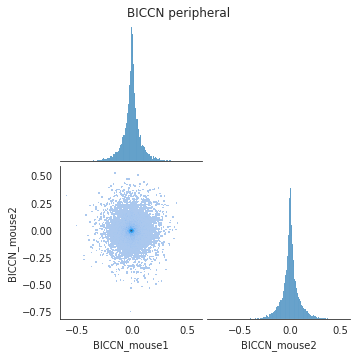

sample,BICCN_mouse1,BICCN_mouse2
sample,,
BICCN_mouse1,1.000000,0.005309
BICCN_mouse2,0.005309,1.000000


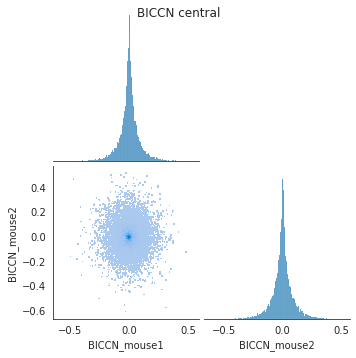

sample,BICCN_mouse1,BICCN_mouse2
sample,,
BICCN_mouse1,1.000000,0.038045
BICCN_mouse2,0.038045,1.000000


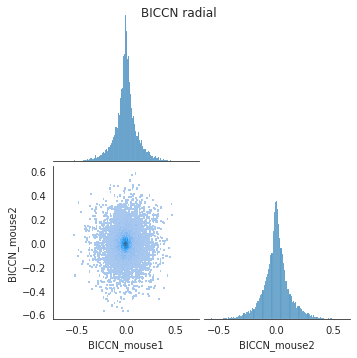

sample,BICCN_mouse1,BICCN_mouse2
sample,,
BICCN_mouse1,1.000000,0.014273
BICCN_mouse2,0.014273,1.000000


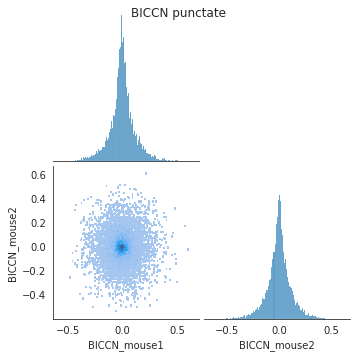

sample,vz_Brainmap_slice1,vz_Brainmap_slice2,vz_Brainmap_slice3
sample,,,
vz_Brainmap_slice1,1.000000,-0.015587,-0.013980
vz_Brainmap_slice2,-0.015587,1.000000,-0.008479
vz_Brainmap_slice3,-0.013980,-0.008479,1.000000


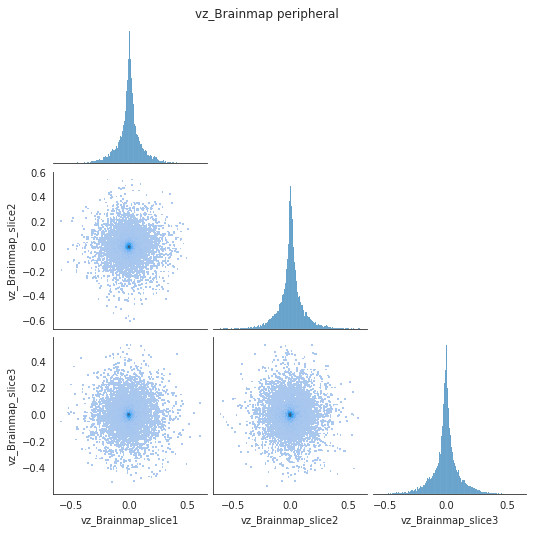

sample,vz_Brainmap_slice1,vz_Brainmap_slice2,vz_Brainmap_slice3
sample,,,
vz_Brainmap_slice1,1.000000,-0.018676,0.001826
vz_Brainmap_slice2,-0.018676,1.000000,-0.014651
vz_Brainmap_slice3,0.001826,-0.014651,1.000000


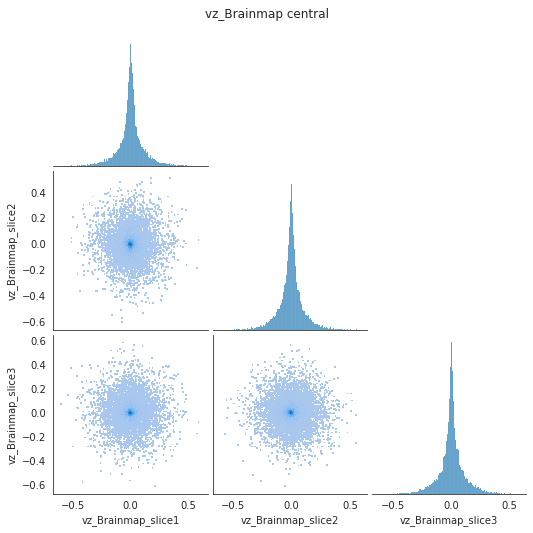

sample,vz_Brainmap_slice1,vz_Brainmap_slice2,vz_Brainmap_slice3
sample,,,
vz_Brainmap_slice1,1.000000,0.007984,-0.016677
vz_Brainmap_slice2,0.007984,1.000000,0.012579
vz_Brainmap_slice3,-0.016677,0.012579,1.000000


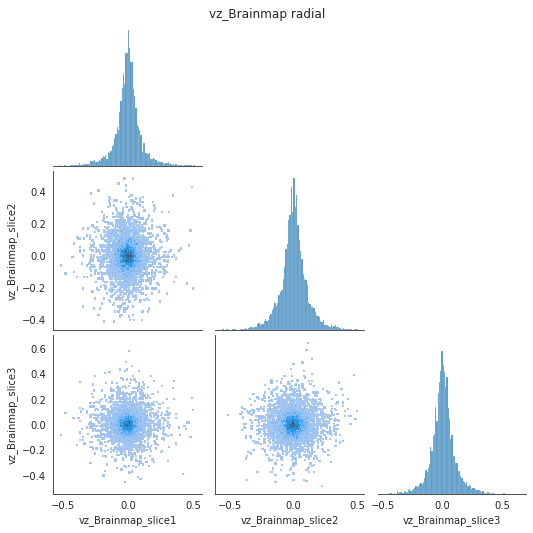

sample,vz_Brainmap_slice1,vz_Brainmap_slice2,vz_Brainmap_slice3
sample,,,
vz_Brainmap_slice1,1.000000,-0.017512,0.008036
vz_Brainmap_slice2,-0.017512,1.000000,-0.055502
vz_Brainmap_slice3,0.008036,-0.055502,1.000000


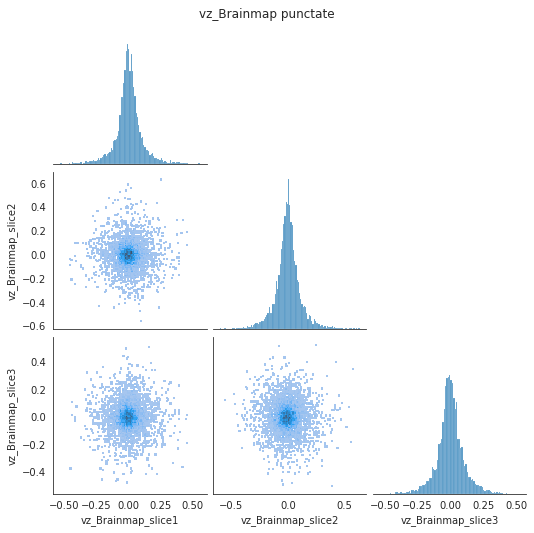

CPU times: user 52.4 s, sys: 599 ms, total: 53 s
Wall time: 54.1 s


In [6]:
%%time
#Pairplots for experiments with replicate samples
#uses the gene/ont datasets for plotting

sns.set_style("white")

metrics = ['peripheral','central','radial','punctate']
experiment_samples = {
    'BICCN':['BICCN_mouse1','BICCN_mouse2'],
    'vz_Brainmap':['vz_Brainmap_slice1','vz_Brainmap_slice2','vz_Brainmap_slice3'],
}

stem = '../../nf_pipeline/outputs/sprawl_20220531_permuted/gene_ont'

for experiment,samples in experiment_samples.items():
    for metric in metrics:
        df = pd.DataFrame()
        for sample in samples:
            f_path = glob.glob(os.path.join(stem,sample)+'*'+metric+'*')
            if not f_path:
                continue
                
            sample_df = pd.read_csv(f_path[0])
            sample_df['sample'] = sample
            df = pd.concat((df,sample_df))
            
        if df.empty:
            continue 
            
        #Pairplot
        sample_pair_df = df.pivot_table(
            index = ['gene','annotation'],
            columns = 'sample',
            values = 'med_score',
            aggfunc = 'median',
        )
        display(sample_pair_df.corr())

        fig = sns.pairplot(
            sample_pair_df,
            kind = 'hist',
            corner = True,
        )
        plt.suptitle('{} {}'.format(experiment,metric))
        plt.savefig(f'gene_ont_pairplots/perm_data_{experiment}_{metric}.svg')
        plt.show(fig)
        plt.close()
        

                    
